# Python project: "Automatic analysis of thermal desorption spectra"

---

The project concerns automatic analysis of spectra obtained using the Thermal Desorption Spectroscopy method and was made by:

Dr. Karol Cieślik 

https://www.linkedin.com/in/karolcieslik/

https://github.com/karol-cieslik

In the project data is imported, cleaned and analyzed. The user can use this notebook to optimize analysis parameters for one data set and then use them for a batch import, cleaning and analysis of all their data.

---

# Plan of the notebook

1. Short introduction
2. Analysis of a single spectrum
    1. Import and basic filtering
    2. Separating the linear region of heating
    3. Filtering of the signal and plotting data
    4. Leading edge analysis (analysis of the first peak)
    5. Redhead analysis (analysis of the second peak)
3. Batch analysis
    1. Batch import
    2. Batch analysis
    3. Exporting the results

# Automatic analysis of thermal desorption spectra 

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px"> 1. Short introduction </p>

<p style="font-family:Sans;font-size:12pt;font-weight:bold">A very short description of the method</p>

Temperature programmed desorption (TPD), also known as thermal desorption spectroscopy (TDS), is an analytical technique which can be used in order to experimentally determine the energy of desorption of various molecular structures present on a surface. In TPD experiment one considers the rate of desorption, and its changes with temperature. The graph of rate of desorption as a function of temperature is called a desorption spectrum.

<figure>
    <img src='images/TDS_scheatic_diagram.PNG' alt='missing' width="500px" height="1000px" />
    <figcaption> Figure 1. Typical TPD setup containing a sample, a heater with a temperature controller,
a mass spectrometer, all in an UHV chamber.   <a href="http://pubman.mpdl.mpg.de/pubman/item/escidoc:738511/component/escidoc:738510/Thermal+analysis+TDS.pdf">Source of the image</a> </figcaption>
</figure>


TDS experiments are conducted in an ultra-high vacuum chamber (UHV) (see fig. 1). First the monocrystal with a well-defined surface is cleaned and then molecules are deposited on it from a crucible. The amount of molecules deposited on the surface is precisely known, as the flux of molecules is always calibrated beforehand on a quartz crystal microbalance. This allows for systematic studies from coverages below one monolayer to thick layer of molecules. During the experiment the sample is heated with a constant rate and the rate of desorption of molecules from the surface is monitored by a mass spectrometer.

The information about the type of desorption, entropy, enthalpy changes etc. is hidden in the shape of the observed peaks, their location on the temperature scale, and in the way that the peaks evolve when the coverages increase.

In this script the most important and time-consuming parts of the analysis of the TDS spectra will be performed and automated.

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px"> 2. Analysis of a single spectrum </p>

<p style="font-family:Sans;font-size:12pt;font-weight:bold"> Importing libraries</p>

This code ensures that the plots will be saved to files the same way as they are shown in the notebook.

In [1]:
%config InlineBackend.print_figure_kwargs = \
    {'bbox_inches':None}

Libraries used in the notebook and their short descriptions.

In [2]:
import pandas as pd # used for the import and export of data and its filtering

import numpy as np # used a lot in this notebook - mostly for array creation and their modyfication
from numpy import median # used in median filtering of the data

from matplotlib import pyplot as plt # used for plotting 

from sklearn.linear_model import LinearRegression # used for linear regression

import scipy 
from scipy import optimize # used to fit functions to data points 
import scipy.constants as sc # scientific constanst with high accuracy 

import os # used later to easily locate and then batch import files from a folder to the Jupyter notebook

import re # it is later used to create shorter names based on file names (when batch import is performed)

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2A. Import and basic filtering</p>

### Importing the data

The data collected by the mass spectrometer's software has to be imported to the notebook. It is written in csv files with first 29 lines of information about the settings of the spectrometer. Furthermore, the temperature data has spikes, meaning that it shows that the temperature sometimes increases drastically for a couple of millisecond or a second - this is a bug in the system and should be removed from the data.


In [3]:
#Loading the data
df = pd.read_csv(
    
    'input/TDS_TiO2(110)_120121_6CC_6.0Hz-DHTA5_1K-s_2xPID_no35.csv',
    skiprows=29,
    index_col = None,
    sep    = ';',
    decimal=','
)

# the empty column is removed
del df['Unnamed: 4'] 
# the column with time in the format hh:mm:ss is not needed and is also removed
del df['Time'] 

df = df.astype(float)

# delete all rows with NaN
df = df.dropna() 

# the time in the data does not start at zero, but at this values, which has to be accounted for 
offset = df.iat[0, 0] 

# addding a column which is offset corrected and the time is in minutes
df['time_min'] = df.apply(lambda x: (x['ms'] - offset) / (1000 *60) , axis=1) 

# redefining the variables for convenience
time_min = np.array(df['time_min'])
# these two columns have to be referred to this way and not by their name,
# becuase these two names change between different files
temperature = np.array(df.iloc[:,[2]])
signal  = np.array(df.iloc[:,[1]]) 

# in the following lines the temperature data is filtered and the spikes are removed 
a = np.array(temperature)
flat_temp = list(np.array(a).flat)
temp_without_spikes = []

# if the changes in temperature are too sudden the value is replaced by NaN
for i in range(len(flat_temp)-1):
    if flat_temp[i+1] > (flat_temp[i] + 1.5) and i != 0 or flat_temp[i+1] < (flat_temp[i] - 0.5):
        temp_without_spikes.append(np.nan)
    elif flat_temp[i] > 800:
        temp_without_spikes.append(np.nan)
    else:
        temp_without_spikes.append(flat_temp[i])

# here the data is saved to the dataframe
temp_without_spikes.append(flat_temp[(len(flat_temp))-1])        
temp_without_spikes = pd.DataFrame(temp_without_spikes) 
df['temp_without_spikes'] = temp_without_spikes

# and now where the data had NaN values are added using interpolation
df = df.interpolate(method='index')

print("This is the imported and filtered data which will be used furter in the notebook")
print(df)

This is the imported and filtered data which will be used furter in the notebook
             ms  DHTA+  Temperatura   time_min  temp_without_spikes
0        1361.0    0.0     100.2946   0.000000            100.29460
1        1694.0    0.0     100.2946   0.005550            100.29460
2        2027.0    0.0     100.2946   0.011100            100.29460
3        2360.0    0.0     101.0641   0.016650            101.76945
4        2694.0    0.0     103.2443   0.022217            103.24430
...         ...    ...          ...        ...                  ...
4074  1359360.0    5.0     338.4539  22.633317            338.32574
4075  1359694.0   10.0     337.6844  22.638883            337.74862
4076  1360027.0    0.0     337.1715  22.644433            337.17150
4077  1360360.0   10.0     336.7867  22.649983            336.72260
4078  1360694.0   15.0     336.2737  22.655550            336.27370

[4079 rows x 5 columns]


### Plotting the imported data   

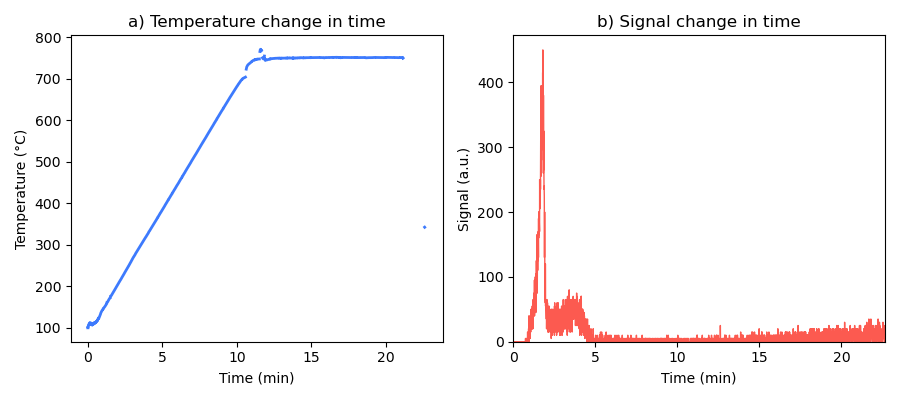

In [4]:
#Here the data is plotted - both the temperature dependence on time and the signal as a function of time 
fig = plt.figure(figsize=(9, 4), dpi=100, facecolor="white")

plt.subplot(1, 2, 1)
plt.plot(time_min, temp_without_spikes,     
        linestyle       = '-',       
        color           ='xkcd:lightish blue',
        linewidth       = 2.0,)
plt.title('a) Temperature change in time')
plt.xlabel('Time (min)')
plt.ylabel(u'Temperature (\u00B0C)')

plt.subplot(1, 2, 2)
plt.plot(time_min, signal,     
        linestyle       = '-',       
        color           ='xkcd:coral',
        linewidth       = 1.0,)
plt.title('b) Signal change in time')
plt.xlabel('Time (min)')
plt.ylabel('Signal (a.u.)')

axes = plt.gca()
axes.set_xlim([0,max(time_min)])
axes.set_ylim([0,(max(signal)+max(signal)/20)])

plt.tight_layout()
plt.show()

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2B. Separating the linear region of heating </p>

### Separating the part of data where the temperature changes linearly

We are only interested in the region where the temperature changes with a linear rate, because such data can be analyzed using typical methods.


In [5]:
# The linear region in almost all of our spectra begins at 125 deg.C. and ends at 700 deg.C 
lower_bound = 125.00
higher_bound = 700

# Here the data is filtered using three conditions - 2 temperature constraints and one time constraint. 
# The time constraint is needed, because somemetimes the measurment is not stopped and cooling is also recorded
# The data from cooling is not needed as it is not useful for the analysis
df_filtered = df[ (df['temp_without_spikes'] >= lower_bound) & (df['temp_without_spikes'] < higher_bound) &(df['time_min'] <= 10.00)  ]

temperature_filt = df_filtered['temp_without_spikes']
time_min_filt = df_filtered['time_min']
signal_filt = df_filtered.iloc[:,[1]]

In [6]:
# Here the functions used for linear regression are defined

# This function takes x, y values and returns coeffictients of linear regression
def linear(x,y):
    resh_x = np.reshape(x, (-1, 1))
    resh_y = np.reshape(y, (-1, 1))
    reg = LinearRegression().fit(resh_x, resh_y)
    intercept = reg.intercept_
    coefficient = reg.coef_
    return  coefficient, intercept

# This function takes x, y values and using the coeffictients of linear regression
# returns the y values of the fit
def pred(x,y):
    resh_x = np.reshape(x, (-1, 1))
    coefficient = linear(x,y)[0]
    intercept = linear(x,y)[1]
    Y_pred = coefficient * resh_x + intercept
    return Y_pred

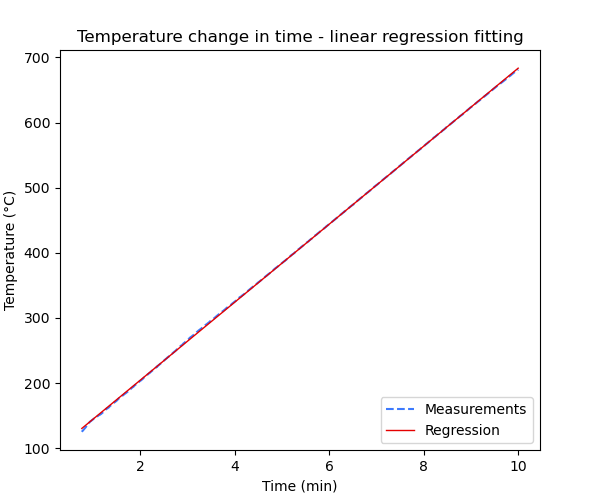

In [7]:
# Now the filtered data and the fit are plotted on one graph 
# to inspect the quality of the fit

fig = plt.figure(figsize=(6, 5), dpi=100, facecolor="white")
ax = fig.add_axes( [.1, .1, .8, .8] )

plot_1, = ax.plot(
    time_min_filt, temperature_filt,
    'xkcd:lightish blue',
    linestyle       = '--',
    )
plot_2, = ax.plot(
    time_min_filt, pred(np.array(time_min_filt),np.array(temperature_filt)), 
    linestyle       = '-',      
    color           = 'xkcd:red',
    zorder=20,
    linewidth       = 1.0, # This makes the fitted line more visible as compared to the raw data
    )
plt.title('Temperature change in time - linear regression fitting')
plt.xlabel('Time (min)')
plt.ylabel(u'Temperature (\u00B0C)')

ax.legend(
    [plot_1, plot_2], ['Measurements', 'Regression'],
    loc = 'lower right',
)
plt.show()

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2C. Filtering of the signal and plotting data</p>

The raw signal is noisy and it should be filtered. Three two filters are proposed: average and median filter. Average filter calculated an average over chosen number of points and returns their average. The median filter does the same thing, but calculates the median instead of the average.

Moreover, now the TDS spectra can be plotted, because using the fitted linear function, the time data can be transformed to temperature data in the linear region.

In [8]:
# The user can choose over how many points he or she will filter the data

def choose_window():
    print("Over how many points do you want to filter? ")
    while True:
        try:
            window = int(input('Select: '))
            if window > 0:
                break
        except:    
            pass
        print("It has to be a natural number")
    return window
window = choose_window()

Over how many points do you want to filter? 
Select: 20


In [9]:
# Here are the filtering functions defined 
def average_signal(signal, window):
    averaged_signal = []
    for i in range(len(signal)):
        end_of_sum = i + window - 1
        sm = sum(signal[i:end_of_sum])
        av = sm / (window)
        averaged_signal.append(av)   
    return averaged_signal    

def median_signal(signal, window):    
    median_signal = []
    for i in range(len(signal)):
        end_of_med = i + window - 1
        med = median(signal[i:end_of_med])
        median_signal.append(med)
    return median_signal

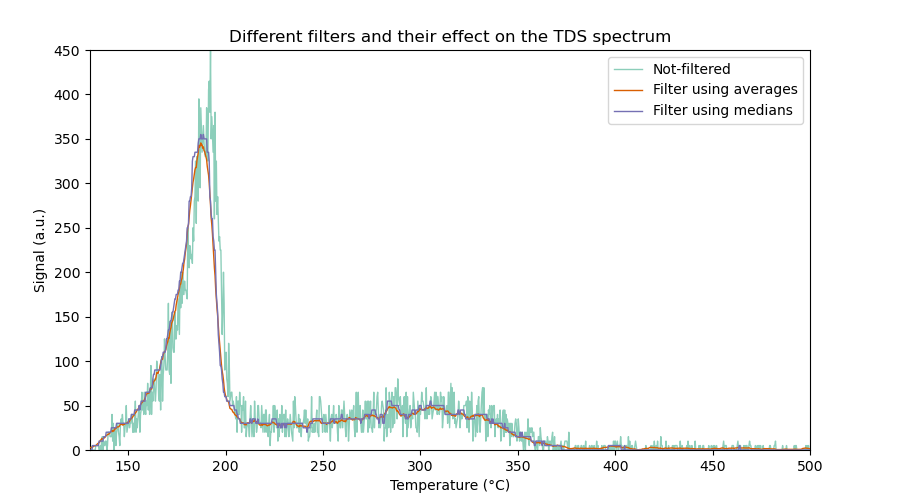

In [10]:
# Here the not filtered data, data filtered using averages and using medians can be compared

# Here is the non-filtered data
temp_from_regression = np.array(pred(np.array(time_min_filt),np.array(temperature_filt)))
signal_filt = np.array(signal_filt) 

# Here is the graph
fig = plt.figure(figsize=(9, 5), dpi=100, facecolor="white")
ax = fig.add_axes( [.1, .1, .8, .8] )

plot_1, = ax.plot(temp_from_regression, signal_filt,     
    linestyle       = '-',       
    color           ='#1b9e77',
    alpha=0.5,
    linewidth       = 1.0, )
plot_2, = ax.plot(
    temp_from_regression, average_signal(signal_filt, window), 
    linestyle       = '-',       
    color           = '#d95f02',
    zorder=20,
    linewidth       = 1.0,
    )
plot_3, = ax.plot(
    temp_from_regression, median_signal(signal_filt, window), 
    linestyle       = '-',       
    color           = '#7570b3',
    zorder=20,
    linewidth       = 1.0,
    )

plt.title('Different filters and their effect on the TDS spectrum')
plt.xlabel(u'Temperature (\u00B0C)')
plt.ylabel('Signal (a.u.)')
axes = plt.gca()

axes.set_xlim([min(temp_from_regression),500])
axes.set_ylim([0,max(signal_filt)])
ax.legend(
    
    [plot_1, plot_2, plot_3], ['Not-filtered', 'Filter using averages', 'Filter using medians'],
    loc = 'upper right',
)
plt.show()         

In [11]:
# the user chooses their preferred filtering method
def choose_method():
    print('Which filtering method do you want to use?')
    print('no filtering', 'average', 'median')
    prefered_method = None
    while prefered_method not in {'no filtering', 'average', 'median'}:
          prefered_method = input("Please enter 'no filtering', 'average' or 'median': ")
    if prefered_method == 'no filtering':
        prefered_method = signal_filt
    elif prefered_method == 'average':
        prefered_method = average_signal(signal_filt, window)
    else:
        prefered_method = median_signal(signal_filt, window)
        
    # in order to later calculate logarithms, the zeros are replaced with a small value 
    prefered_method = [x if x > 0 else 1 for x in prefered_method]
    prefered_method = np.array(prefered_method)
    prefered_method = prefered_method.astype(float)
    prefered_method = prefered_method.tolist()
    
    return prefered_method
prefered_method = choose_method()

Which filtering method do you want to use?
no filtering average median
Please enter 'no filtering', 'average' or 'median': median


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2D. Leading edge analysis (analysis of the first peak)</p>

For first peak (desorption of the zeroth order), the relationship between rate of desorption and temperature can be described using this equation:

\begin{equation}
\ln{ R_{des}} = \ln{\left(\frac{\nu_{0}}{\beta} \right) } - \frac{E_{des}}{kT},
\end{equation}
where $R_{des}$ is the rate of desorption, $\nu_{0}$ is the kinetic coefficient  of the zeroth order desorption, $\beta$ is the rate of heating, $E_{des}$ is the energy of desorption, $T$ is the temperature, $k$ is the Boltzmann constant.

(the first peak is asymmetric and has a sudden drop which is characteristic of the 0-th order desorption typical for multilayers of molecules)

The leading edge analysis is based on fitting a linear function to the leading edge of the desorption peak - the slope contains information about the energy of desorption while the point where the line crosses the y-axis contains information about the kinetic coefficient.

In [12]:
# First the user chooses the range for which the line will be fitted
print('For the first peak I suggest lower bound of 130 and higher bound of 170')
def choose_bounds():
    ymax = max(prefered_method)
    xpos = prefered_method.index(ymax)
    xmax = temp_from_regression[xpos]
    higher_bound = xmax
    print('The data starts at 125')
    print('The maximum of the zeroth peak is at', xmax)
    lower_bound = int(input("Put in the lower bound "))
    higher_bound = int(input("Put in the higher bound "))
    return lower_bound, higher_bound
bounds = choose_bounds()
lower_bound = bounds[0]
higher_bound = bounds[1]

For the first peak I suggest lower bound of 130 and higher bound of 170
The data starts at 125
The maximum of the zeroth peak is at [187.25061635]
Put in the lower bound 125
Put in the higher bound 170


In [13]:
# A function is needed to constrain the data given the bounds 
def binding_fun(lower,upper,data_x,data_y):
    lower_counter = 0
    for elem in data_x:
        if elem <= lower:
            lower_counter = lower_counter + 1 
        else:
            break
    higher_counter = 0
    for elem in data_x:
        if elem <= upper:
            higher_counter = higher_counter + 1 
        else:
            break

    bound_data_x = data_x[lower_counter:higher_counter]
    
    bound_data_y = data_y[lower_counter:higher_counter]    
    
    return bound_data_x, bound_data_y 

In [14]:
# Here is a function which calculates logarythm and inverse of temperature
def arrhenius(x,y):
    # the input temp should be in celsius
    inverse_temp = 1/(x + 273.15) 
    ln_signal = np.log(y)
    return inverse_temp, ln_signal

The desorption energy will be calculated based on the data from the shaded area


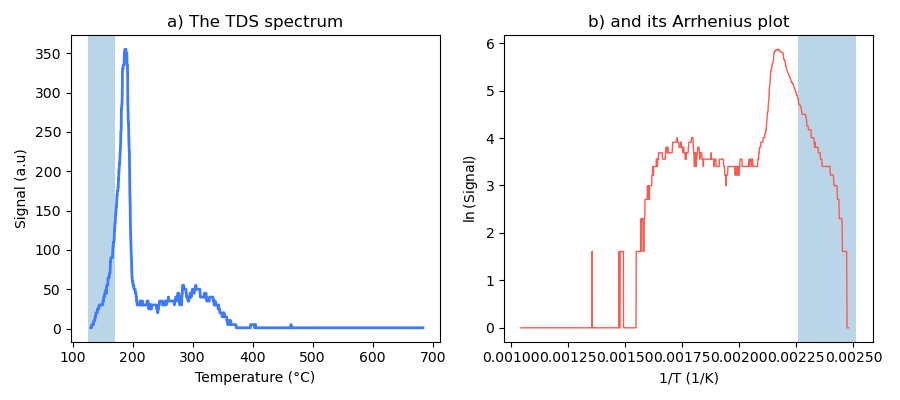

In [15]:
# The user can see here the data from which the analysis will be performed 

print('The desorption energy will be calculated based on the data from the shaded area')

fig = plt.figure(figsize=(9, 4), dpi=100, facecolor="white")
plt.subplot(1, 2, 1)
plt.plot(temp_from_regression, prefered_method,     
        linestyle       = '-',       
        color           ='xkcd:lightish blue',
        linewidth       = 2.0,)
plt.title('a) The TDS spectrum')
plt.xlabel(u'Temperature (\u00B0C)')
plt.ylabel('Signal (a.u)')

plt.axvspan(lower_bound, higher_bound, alpha=0.3)
plt.subplot(1, 2, 2)

plt.plot(arrhenius(temp_from_regression,prefered_method)[0], arrhenius(temp_from_regression,prefered_method)[1], 
        linestyle       = '-',       
        color           ='xkcd:coral',
        linewidth       = 1.0,)
plt.title('b) and its Arrhenius plot')
plt.xlabel('1/T (1/K)')
plt.ylabel(r'$\ln{(\mathrm{Signal})} $')

temp1 = 1/(lower_bound+273.15)
temp2 = 1/((higher_bound)+273.15)

plt.axvspan(temp1, temp2,alpha=0.3)
plt.tight_layout()
plt.show()

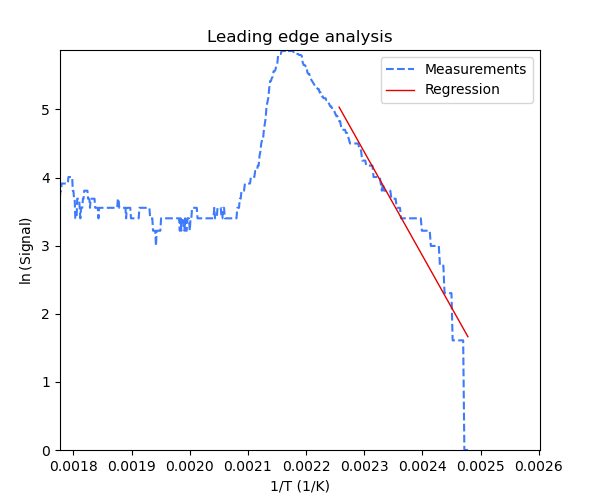

In [16]:
# Here is the fitted line shown on a graph
temp_from_regression_restrained = binding_fun(lower_bound,higher_bound,temp_from_regression,prefered_method)[0]
prefered_method_restreained = binding_fun(lower_bound,higher_bound,temp_from_regression,prefered_method)[1]

fig = plt.figure(figsize=(6, 5), dpi=100, facecolor="white")

ax = fig.add_axes( [.1, .1, .8, .8] )

plot_1, = ax.plot(
    arrhenius(temp_from_regression,prefered_method)[0], arrhenius(temp_from_regression,prefered_method)[1],
    'xkcd:lightish blue',
    linestyle       = '--',
    )
plot_2, = ax.plot(
    arrhenius(temp_from_regression_restrained,prefered_method_restreained)[0], pred(arrhenius(temp_from_regression_restrained,prefered_method_restreained)[0],arrhenius(temp_from_regression_restrained,prefered_method_restreained)[1]),
    linestyle       = '-',      
    color           = 'xkcd:red',
    zorder=20,
    linewidth       = 1.0,
    )
plt.title('Leading edge analysis')
plt.xlabel('1/T (1/K)')
plt.ylabel(r'$\ln{(\mathrm{Signal})} $')

ax = plt.gca()
ax.set_xlim([1.7*min(arrhenius(temp_from_regression,prefered_method)[0]),1.05* max(arrhenius(temp_from_regression,prefered_method)[0])])
ax.set_ylim([min(arrhenius(temp_from_regression,prefered_method)[1]),max(arrhenius(temp_from_regression,prefered_method)[1])])

ax.legend(
    
    [plot_1, plot_2], ['Measurements', 'Regression'],
    loc = 'upper right',
)
plt.show()

### calculating 0-th order peak parameters - energy and kinetic coefficient

In [17]:
# using this function the parameters are calculated
# it is based on the previously shown equation 
def des_energy_zeroth(x,y):
    rate = linear(np.array(time_min_filt),np.array(temperature_filt))[0]/60 #in kelvin/sec
    coefficient = linear(x,y)[0]
    intercept = linear(x,y)[1]
    energy = - coefficient * sc.k / sc.e #in eV
    energy = energy.item()
    kinetic_coeff = rate.item()*np.exp(intercept.item())
    return  energy, kinetic_coeff

energy = des_energy_zeroth(arrhenius(temp_from_regression_restrained,prefered_method_restreained)[0],arrhenius(temp_from_regression_restrained,prefered_method_restreained)[1])[0]
kinetic_par_zero = des_energy_zeroth(arrhenius(temp_from_regression_restrained,prefered_method_restreained)[0],arrhenius(temp_from_regression_restrained,prefered_method_restreained)[1])[1]

# the data will be shown in a user-friendly way - with less decimal points
print('Energy is equal to', "%.3f" % energy, 'eV' )
print('Kinetic coefficient is equal to', '{:.2e}'.format(kinetic_par_zero) , '1/s' )

Energy is equal to 1.312 eV
Kinetic coefficient is equal to 1.28e+17 1/s


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2E. Redhead analysis (analysis of the second peak)</p>

For second peak (desorption of the first order), the desorption energy can be calculated using the Redhead equation:

\begin{equation}
E_{des} \approx RT_{max}\left[ \ln{\left(\frac{\nu_{1}T_{max}}{\beta}  \right) } - 3.64 \right],
\end{equation}

where $\nu_{1}$ is the kinetic coefficient  of the **first** order desorption, $\beta$ is the rate of heating, $T_{max}$ is the temperature for which the peak maximum occurs, $R$ is the gas constant.

(the second peak maximum is not dependent on coverage (this will be shown later) which is typical for the first monolayer of molecules)

This method requires the kinetic coefficient of the first order desorption which has to be calculated using another method (for example using the heating rate variation method). For the purpose of this project the kinetic coefficient of the zeroth order will be used. This is not uncommon - typically analysis of the first order peaks starts (and sometimes ends) this way.

In [18]:
rate = linear(np.array(time_min_filt),np.array(temperature_filt))[0]/60

# the function which calculates energy using the Redhead equation is defined here 

def redhead(t_max,kinetic_coeff, rate):
    # the input temp. should be in celsius
    #input rate should be per minute
    rate = rate/60
    energy = sc.gas_constant * (t_max +273.15) * (np.log((kinetic_coeff*t_max)/rate)-3.64)
    energy = energy / sc.e / sc.N_A
    energy = energy.item()
    return  energy

In [19]:
print('I recommend taking 220C as the lower boundary and 400C as the higher boundary')
bounds = choose_bounds()
lower_bound = bounds[0]
higher_bound = bounds[1]

I recommend taking 220C as the lower boundary and 400C as the higher boundary
The data starts at 125
The maximum of the zeroth peak is at [187.25061635]
Put in the lower bound 220
Put in the higher bound 400


In order to calculate the energy, the temperature for which maximum signal occurs is needed. Three methods of obtaining this value will be tested - fitting a gauss, fitting a lorentzian and simply finding the coordinates of the maximum using very filtered signal.

In [20]:
# Here the fitted functions are defined
def gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def lorentzian(x, amp1, cen1, wid1):
    return amp1*wid1**2/((x-cen1)**2+wid1**2)

In [21]:
temp_from_regression_restrained = binding_fun(lower_bound,higher_bound,temp_from_regression,prefered_method)[0]
prefered_method_restreained = binding_fun(lower_bound,higher_bound,temp_from_regression,prefered_method)[1]

# before the optimalization can be performed, the data has to transformed to appropriate form 
x = np.array(temp_from_regression_restrained)
x = x.reshape(-1)
y = np.array(prefered_method_restreained)
y = y.reshape(-1)

# the parameters are: the center, the amplitude, and the sigma value of the gauss - these are the starting parameters
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(gaussian, x, y, p0=[60, 380, 20]) 
# here the fitted parameters are put into the gaussian and the y value is calculated
y_gauss = gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2])

# the parameters are: the center, the amplitude, and the sigma value of the lorentzian - these are the starting parameters
popt_lore, pcov_lore = scipy.optimize.curve_fit(lorentzian, x, y, p0=[60, 380, 20]) 
# here the fitted parameters are put into the gaussian and the y value is calculated
y_lore = lorentzian(x, popt_lore[0], popt_lore[1], popt_lore[2])

##############################################################################################
# The signal is filtered in order to later use this in finding the position of the maximum
super_smooth = average_signal(prefered_method_restreained, 35)

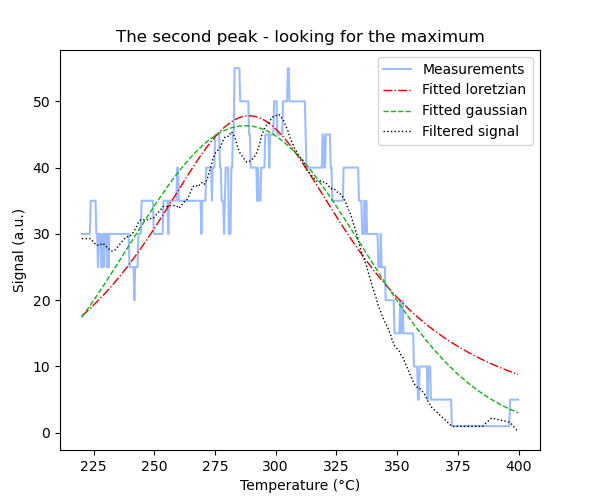

In [22]:
# All of the methods are compared here on one graph
fig = plt.figure(figsize=(6, 5), dpi=100, facecolor="white")

ax = fig.add_axes( [.1, .1, .8, .8] )
plot_1, = ax.plot(
    temp_from_regression_restrained, prefered_method_restreained,
    'xkcd:lightish blue',
    linestyle       = '-',
    alpha=0.5,
    )
plot_2, = ax.plot(
    x, y_lore, 
    linestyle       = '-.',
    color           = 'xkcd:red',
    zorder=30,
    linewidth       = 1.0,
    )
plot_3, = ax.plot(
    x, y_gauss, 
    linestyle       = '--',       
    color           = 'xkcd:green',
    zorder=30,
    linewidth       = 1.0,
    )
plot_4, = ax.plot(
    temp_from_regression_restrained, super_smooth, 
    linestyle       = ':',       
    color           = 'xkcd:black',
    zorder=50,
    linewidth       = 1.0,
    )
plt.title('The second peak - looking for the maximum')
plt.xlabel(u'Temperature (\u00B0C)')
plt.ylabel('Signal (a.u.)')
ax.legend(
    [plot_1, plot_2, plot_3, plot_4], ['Measurements', 'Fitted loretzian', 'Fitted gaussian', 'Filtered signal'],
    loc = 'upper right',
)
plt.show()

In [23]:
# Taking the very filtered singnal as the input, the maximum value is found
ymax = max(super_smooth)
# and then the corresponding temperature 
xpos = super_smooth.index(ymax)
xmax = temp_from_regression_restrained[xpos]
xmax = xmax[0]

# now the temperatures can be compared
print('Acording to the gaussian fit, the peak maximum occurs at', "%.2f" % popt_gauss[1], 'C' )
print('Acording to the lorentzian fit, the peak maximum occurs at', "%.2f" % popt_lore[1], 'C' )
print('Acording to the filtered signal, the peak maximum occurs at', "%.2f" % xmax, 'C' )

Acording to the gaussian fit, the peak maximum occurs at 287.44 C
Acording to the lorentzian fit, the peak maximum occurs at 289.05 C
Acording to the filtered signal, the peak maximum occurs at 301.01 C


All of the methods give similar results, but simply smoothing the signal seems to give the best results. 

In [24]:
zeroth_kinetic = kinetic_par_zero
energy = redhead(xmax,zeroth_kinetic,rate)
print('Assuming that the first kinetic parameter is equal to the zeroth kinetic parameter, \nthe energy is equal to', "%.3f" % energy, 'eV')

Assuming that the first kinetic parameter is equal to the zeroth kinetic parameter, 
the energy is equal to 2.254 eV


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">4A. Batch import</p>

Now that the method has been tested for one file, the next step is to automate the data analysis further, so that all files in a folder automatically go through this. 

In [25]:
# These are the files present in the input folder

root_dir = './input'
  
for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        print(os.path.join(directory, file))

./input\TDS_TiO2(110)_120121_6CC_1.0Hz-DHTA5_1K-s_2xPID_no40.csv
./input\TDS_TiO2(110)_120121_6CC_1.2Hz-DHTA5_1K-s_2xPID_no39.csv
./input\TDS_TiO2(110)_120121_6CC_1.6Hz-DHTA5_1K-s_2xPID_no38.csv
./input\TDS_TiO2(110)_120121_6CC_12.0Hz-DHTA5_1K-s_2xPID_no34.csv
./input\TDS_TiO2(110)_120121_6CC_2.0Hz-DHTA5_1K-s_2xPID_no37.csv
./input\TDS_TiO2(110)_120121_6CC_3.0Hz-DHTA5_1K-s_2xPID_no36.csv
./input\TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPID_no41.csv
./input\TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPID_no42.csv
./input\TDS_TiO2(110)_120121_6CC_6.0Hz-DHTA5_1K-s_2xPID_no35.csv


In [26]:
# In this part the data is automatically read and filtered and put into proper lists 
all_data_time = []
all_data_temp = []
all_data_signal = []
all_data_median_signal = []
all_data_names = []
all_data_temp_reg = []
all_data_temp_reg_slope = []
all_data_temp_inv = []
all_data_log_sig = []

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        df = pd.read_csv(

            os.path.join(directory, file),
            skiprows=29,
            index_col = None,
            sep    = ';',
            decimal=','
        )
        ###############################################################################
        # Correcting for offset and cleaning the input 
        del df['Unnamed: 4']
        del df['Time']
        df = df.astype(float)
        df = df.dropna() 
        offset = df.iat[0, 0] 
        df['time_min'] = df.apply(lambda x: (x['ms'] - offset) / (1000 *60) , axis=1) 
        time_min = np.array(df['time_min'])
        temperature = np.array(df.iloc[:,[2]])
        signal  = np.array(df.iloc[:,[1]])
        #######################################################################################
        # Filtering spikes in temperature 
        a = np.array(temperature)
        flat_temp = list(np.array(a).flat)
        temp_without_spikes = []
        for i in range(len(flat_temp)-1):
            if flat_temp[i+1] > (flat_temp[i] + 1.5) and i != 0 or flat_temp[i+1] < (flat_temp[i] - 0.5):
                temp_without_spikes.append(np.nan)
            elif flat_temp[i] > 800:
                temp_without_spikes.append(np.nan)
            else:
                temp_without_spikes.append(flat_temp[i])
        temp_without_spikes.append(flat_temp[(len(flat_temp))-1])        
        temp_without_spikes = pd.DataFrame(temp_without_spikes) 
        df['temp_without_spikes'] = temp_without_spikes
        df = df.interpolate(method='index')
        lower_bound = 125.00
        higher_bound = 700

        df_filtered = df[ (df['temp_without_spikes'] >= lower_bound) & (df['temp_without_spikes'] < higher_bound) &(df['time_min'] <= 10.00)  ]
        temperature_filt = df_filtered['temp_without_spikes']
        time_min_filt = df_filtered['time_min']
        
        #################################################################################
        signal_filt = df_filtered.iloc[:,[1]]
        all_data_time.append(time_min_filt)
        all_data_temp.append(temperature_filt) 
        all_data_signal.append(signal_filt)
        
        ##############################################################################
        # File name has been added to the dataframe
        all_data_names.append(file) 
        
        ###################################################################################
        # Median filter has been chosen as the best filter
        median_sig = median_signal(signal_filt, 10)
        all_data_median_signal.append(median_sig)
        median_sig = [x if x > 0 else 1 for x in median_sig]
        median_sig = np.array(median_sig)
        median_sig = median_sig.astype(float)
        median_sig = median_sig.tolist()
        #############################################################################################
        # Files can have different heating rates - here they are calculated and added to a list
        temp_from_regression = np.array(pred(np.array(time_min_filt),np.array(temperature_filt)))
        slope = linear(np.array(time_min_filt),np.array(temperature_filt))[0]
        all_data_temp_reg_slope.append(slope)
        
        all_data_temp_reg.append(temp_from_regression)
        ###############################################################################################
        # here are the transformations of data later used in the leading edge analysis
        inv_temp = arrhenius(temp_from_regression,median_sig)[0]
        all_data_temp_inv.append(inv_temp)
        log_sig = arrhenius(temp_from_regression,median_sig)[1]
        all_data_log_sig.append(log_sig)
        

In [27]:
# Regular expressions are used to shorten the names
legend_for_graph = []
for elem in all_data_names:
    shorter = re.search(r'6CC_(.*?)_2xPID', elem).group(1)
    legend_for_graph.append(shorter)

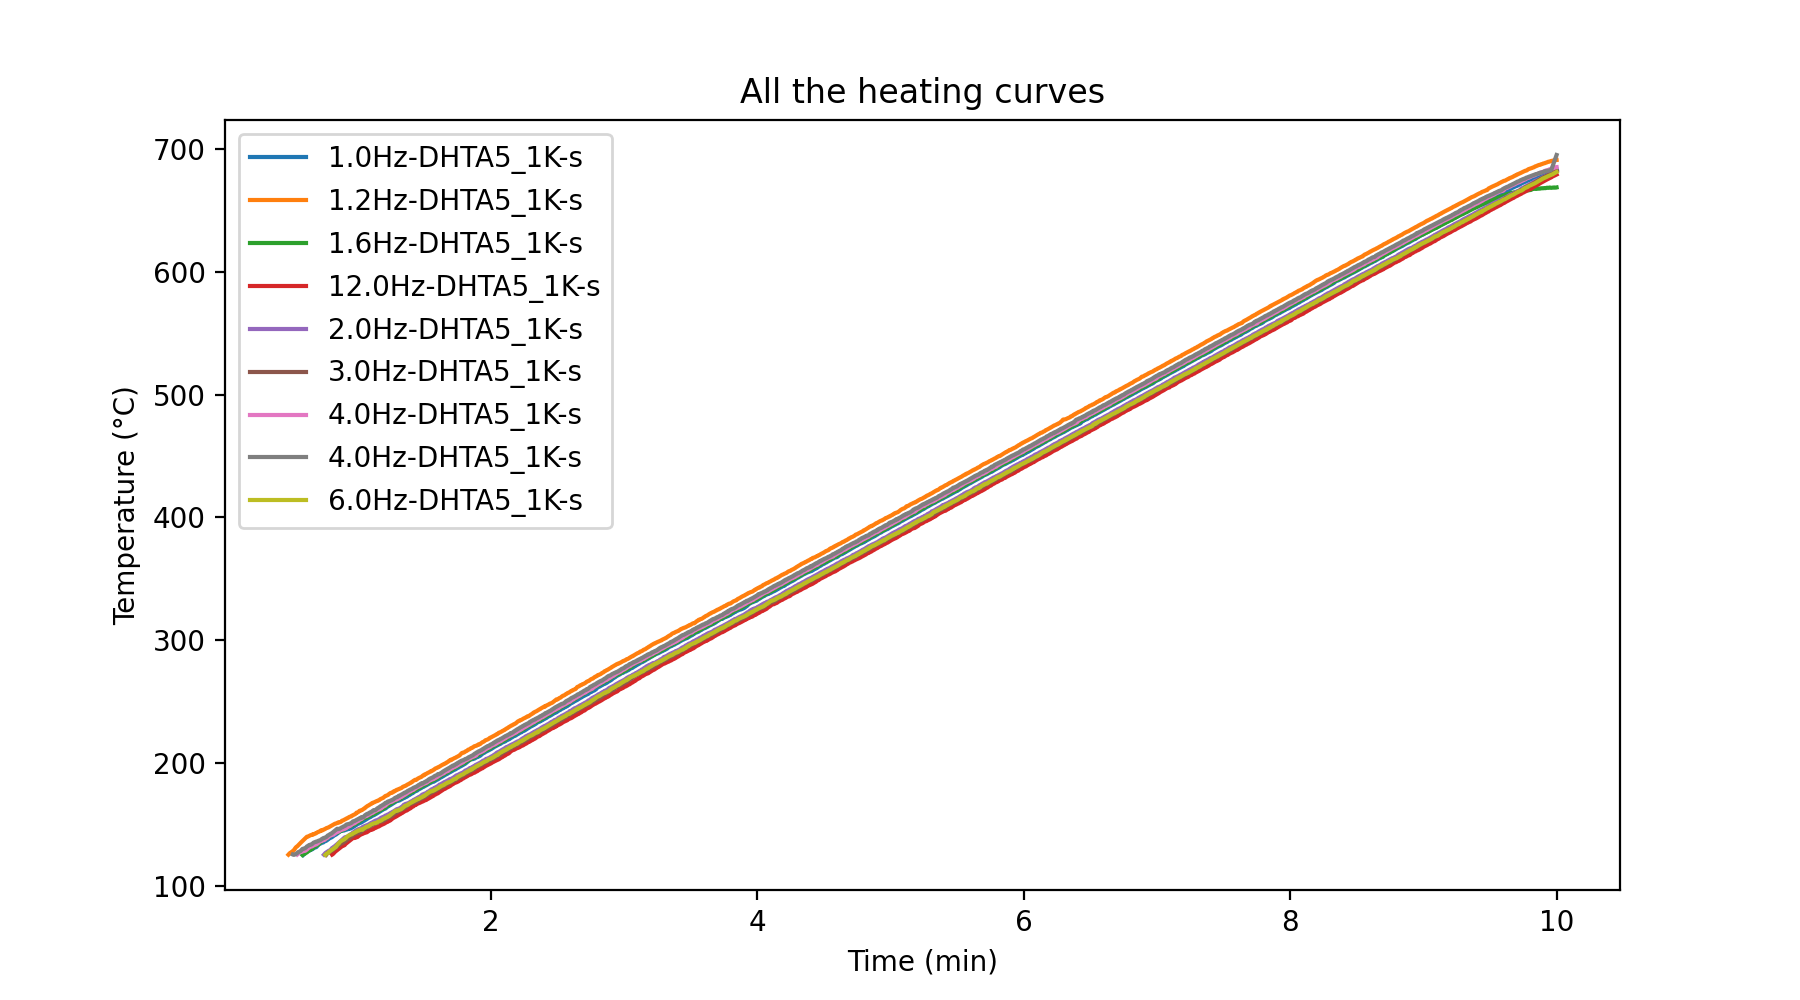

In [28]:
# the user can check if the heating curves are ok or if they have some anomalies
fig = plt.figure(figsize=(9, 5), dpi=200, facecolor="white")
for i in range(len(all_data_temp)):
    plt.plot(all_data_time[i],all_data_temp[i], label=legend_for_graph[i])
    plt.legend(loc='best')
    #plt.legend((legend_for_graph[i]), loc='upper right', fontsize='x-large')
plt.title('All the heating curves')
plt.xlabel('Time (min)')
plt.ylabel(u'Temperature (\u00B0C)')
plt.show()

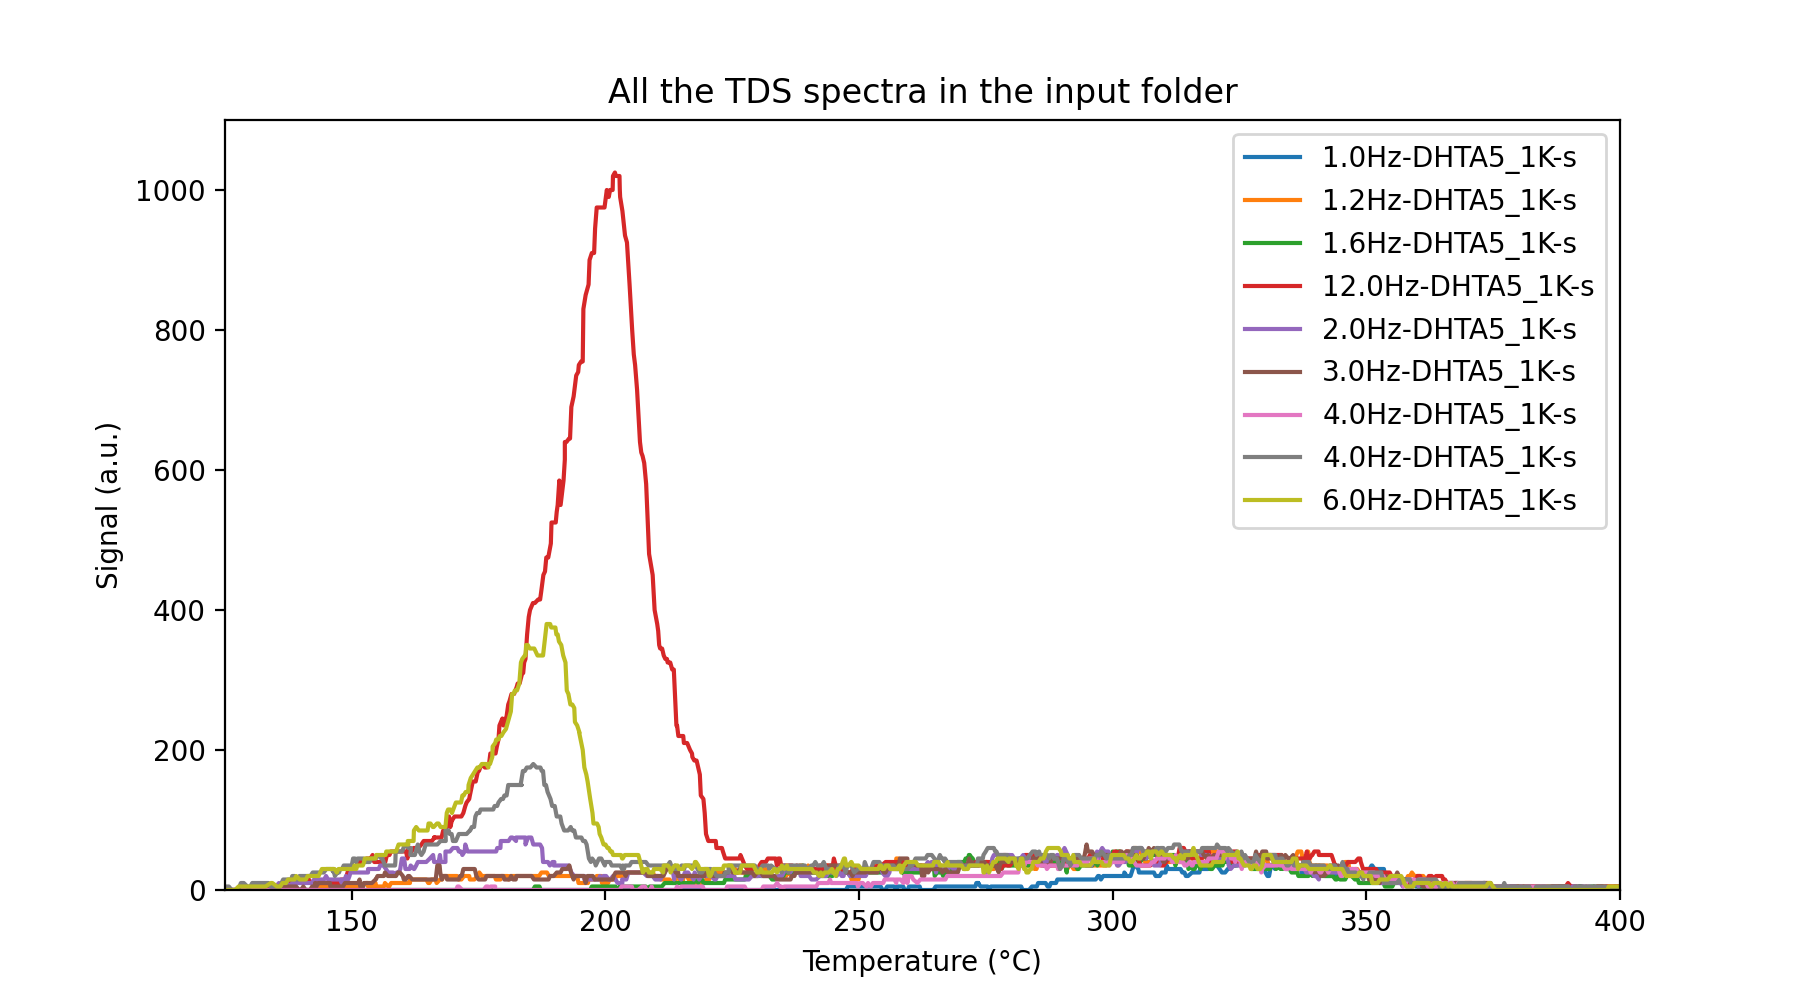

In [29]:
# All the spectra for different coveages are here
fig = plt.figure(figsize=(9, 5), dpi=200, facecolor="white")
for i in range(len(all_data_temp)):
    plt.plot(all_data_temp[i],all_data_median_signal[i], label=legend_for_graph[i])
    plt.legend(loc='best')
    #plt.legend((legend_for_graph[i]), loc='upper right', fontsize='x-large')
plt.title('All the TDS spectra in the input folder')
plt.xlabel(u'Temperature (\u00B0C)')
plt.ylabel('Signal (a.u.)')
axes = plt.gca()
axes.set_xlim([125,400])
axes.set_ylim([0,1100])

#The file is saved to the output folder
plt.savefig('output/all_tds_spectra.png')
plt.show()

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">4B. Batch analysis <br> 4C. Exporting the results <br></p>

### calculating 0-th order peak parameters - energy and kinetic coefficient

In [30]:
# first the user chooses the boundaries 
bounds = choose_bounds()
lower_bound = bounds[0]
higher_bound = bounds[1]

all_data_inverse_temp_restreained = []
all_data_ln_signal_restreained = []

# the temperature is restrained and inversed
for elem in all_data_temp_reg:
    temp_from_regression_restrained = [i for i in elem if i >= lower_bound and i <= higher_bound]
    inverse_temp_restreained = 1/(np.array(temp_from_regression_restrained) + 273.15) 
    all_data_inverse_temp_restreained.append(inverse_temp_restreained)

# and then the logarithm of the signal is calculated 
numerator = 0
for elem in all_data_median_signal:
    start = 0
    end = len(all_data_inverse_temp_restreained[numerator])
    
    prefered_method = [x if x > 0 else 1 for x in elem]
    prefered_method = np.array(prefered_method)
    prefered_method = prefered_method.astype(float)
    prefered_method = prefered_method.tolist()
    
    prefered_method_restreained = prefered_method[start:end]
    
    ln_signal_restreained = np.log(prefered_method_restreained)
    all_data_ln_signal_restreained.append(ln_signal_restreained)

    numerator = numerator + 1 

The data starts at 125
The maximum of the zeroth peak is at [187.25061635]
Put in the lower bound 125
Put in the higher bound 180


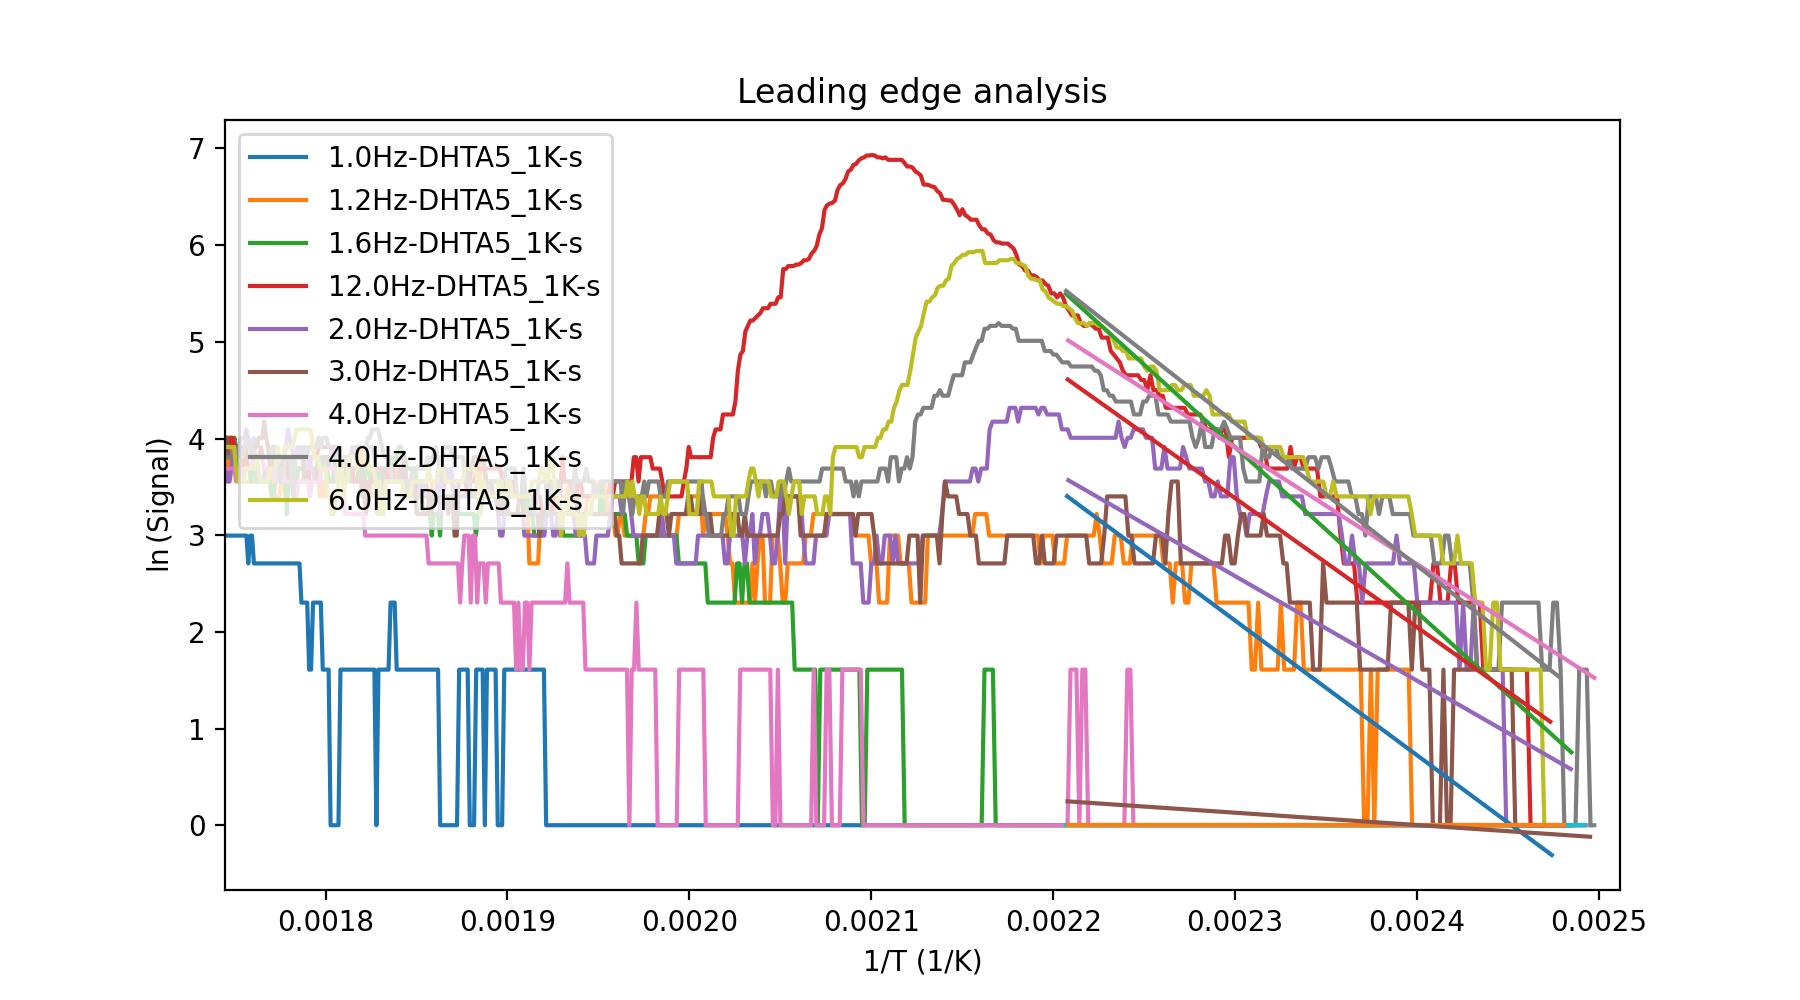

In [31]:
fig = plt.figure(figsize=(9, 5), dpi=200, facecolor="white")

# Here the user can see all the spectra with the fitted lines for the leading edge analysis

for i in range(len(all_data_temp)):
    plt.plot(all_data_temp_inv[i],all_data_log_sig[i], label=legend_for_graph[i])
    plt.legend(loc='upper left')

for i in range(len(all_data_temp)):
    plt.plot(all_data_inverse_temp_restreained[i], pred(all_data_inverse_temp_restreained[i],np.array(all_data_ln_signal_restreained[i])))
    
plt.title('Leading edge analysis')
plt.xlabel('1/T (1/K)')
plt.ylabel(r'$\ln{(\mathrm{Signal})} $')

axes = plt.gca()
temp1 = 1/(125+273.15)
temp2 = 1/(300+273.15)
axes.set_xlim([temp2,temp1])

plt.show()

In [32]:
# The parameters calculated from the leading edge analysis are put into a list 
# Later, with parameters from Redhead analysis, they will be exported to a csv file

all_0th_energies = []
all_0th_kintetic = []
short_names = legend_for_graph

for i in range(len(all_data_temp)):
    energy = des_energy_zeroth(np.array(all_data_inverse_temp_restreained[i]),np.array(all_data_ln_signal_restreained[i]))[0]
    all_0th_energies.append(energy) 
    coefficitent = des_energy_zeroth(np.array(all_data_inverse_temp_restreained[i]),np.array(all_data_ln_signal_restreained[i]))[1]
    all_0th_kintetic.append(coefficitent) 
    
df = pd.DataFrame(list(zip(all_data_names, short_names,all_0th_energies, all_0th_kintetic )), columns =['File name', 'Short name', 'Des. energy of the 0th peak', 'Kinetic coff. for the oth peak']) 

df

,File name,Short name,Des. energy of the 0th peak,Kinetic coff. for the oth peak
0,TDS_TiO2(110)_120121_6CC_1.0Hz-DHTA5_1K-s_2xPI...,1.0Hz-DHTA5_1K-s,0.000000,9.978565e-01
1,TDS_TiO2(110)_120121_6CC_1.2Hz-DHTA5_1K-s_2xPI...,1.2Hz-DHTA5_1K-s,1.200195,6.770328e+14
2,TDS_TiO2(110)_120121_6CC_1.6Hz-DHTA5_1K-s_2xPI...,1.6Hz-DHTA5_1K-s,0.000000,9.978565e-01
3,TDS_TiO2(110)_120121_6CC_12.0Hz-DHTA5_1K-s_2xP...,12.0Hz-DHTA5_1K-s,1.471030,5.607671e+18
4,TDS_TiO2(110)_120121_6CC_2.0Hz-DHTA5_1K-s_2xPI...,2.0Hz-DHTA5_1K-s,1.149908,6.272865e+14
5,TDS_TiO2(110)_120121_6CC_3.0Hz-DHTA5_1K-s_2xPI...,3.0Hz-DHTA5_1K-s,0.932098,8.369299e+11
6,TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPI...,4.0Hz-DHTA5_1K-s,0.109833,2.130460e+01
7,TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPI...,4.0Hz-DHTA5_1K-s,1.039563,5.574143e+13
8,TDS_TiO2(110)_120121_6CC_6.0Hz-DHTA5_1K-s_2xPI...,6.0Hz-DHTA5_1K-s,1.269358,3.303545e+16


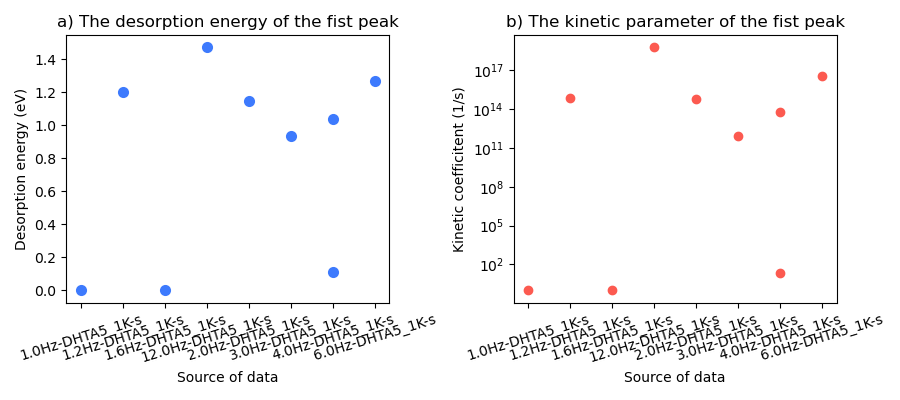

In [33]:
# Here all of the parameters from leading edge analysis are plotted on a scatter graph 
# So the user can inspect them 
fig = plt.figure(figsize=(9, 4), dpi=100, facecolor="white")

plt.subplot(1, 2, 1)
plt.scatter(short_names, all_0th_energies,           
        color           ='xkcd:lightish blue',
        linewidth       = 2.0,)
plt.title('a) The desorption energy of the fist peak')
plt.xlabel('Source of data')
plt.ylabel('Desorption energy (eV)')
plt.xticks(rotation=17)

plt.subplot(1, 2, 2)

plt.scatter(short_names, all_0th_kintetic,       
        color           ='xkcd:coral',
        linewidth       = 1.0,)
plt.yscale('log')
plt.title('b) The kinetic parameter of the fist peak')
plt.xlabel('Source of data')
plt.ylabel('Kinetic coefficitent (1/s)')
plt.xticks(rotation=17)
#####################################################
#The file is saved to the output folder
plt.savefig('output/1st_peak_parameters.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

### calculating 1-st order peak parameters - energy and kinetic coefficient (Redhead equation)

In [34]:
# The user chooses the bounds
print('I suggest 230C and 400C')
bounds = choose_bounds()
lower_bound = bounds[0]
higher_bound = bounds[1]

I suggest 230C and 400C
The data starts at 125
The maximum of the zeroth peak is at [189.57861565]
Put in the lower bound 230
Put in the higher bound 400


In [35]:
# The data is bound 
all_data_temp_reg_bound = []
all_data_median_signal_bound = []

for temp, signal in zip(all_data_temp_reg, all_data_median_signal):
    all_data_temp_reg_bound.append(binding_fun(lower_bound,higher_bound,temp,signal)[0]) 
    all_data_median_signal_bound.append(binding_fun(lower_bound,higher_bound,temp,signal)[1]) 

In [36]:
# The location of maxima is found
all_maxima = []
all_maxima_y = []
for temp, signal in zip(all_data_temp_reg_bound, all_data_median_signal_bound):
    super_smooth = average_signal(signal, 20)
    ymax = max(super_smooth)
    xpos = super_smooth.index(ymax)
    xmax = temp[xpos]
    xmax = xmax[0]
    all_maxima.append(xmax) 
    all_maxima_y.append(ymax) 

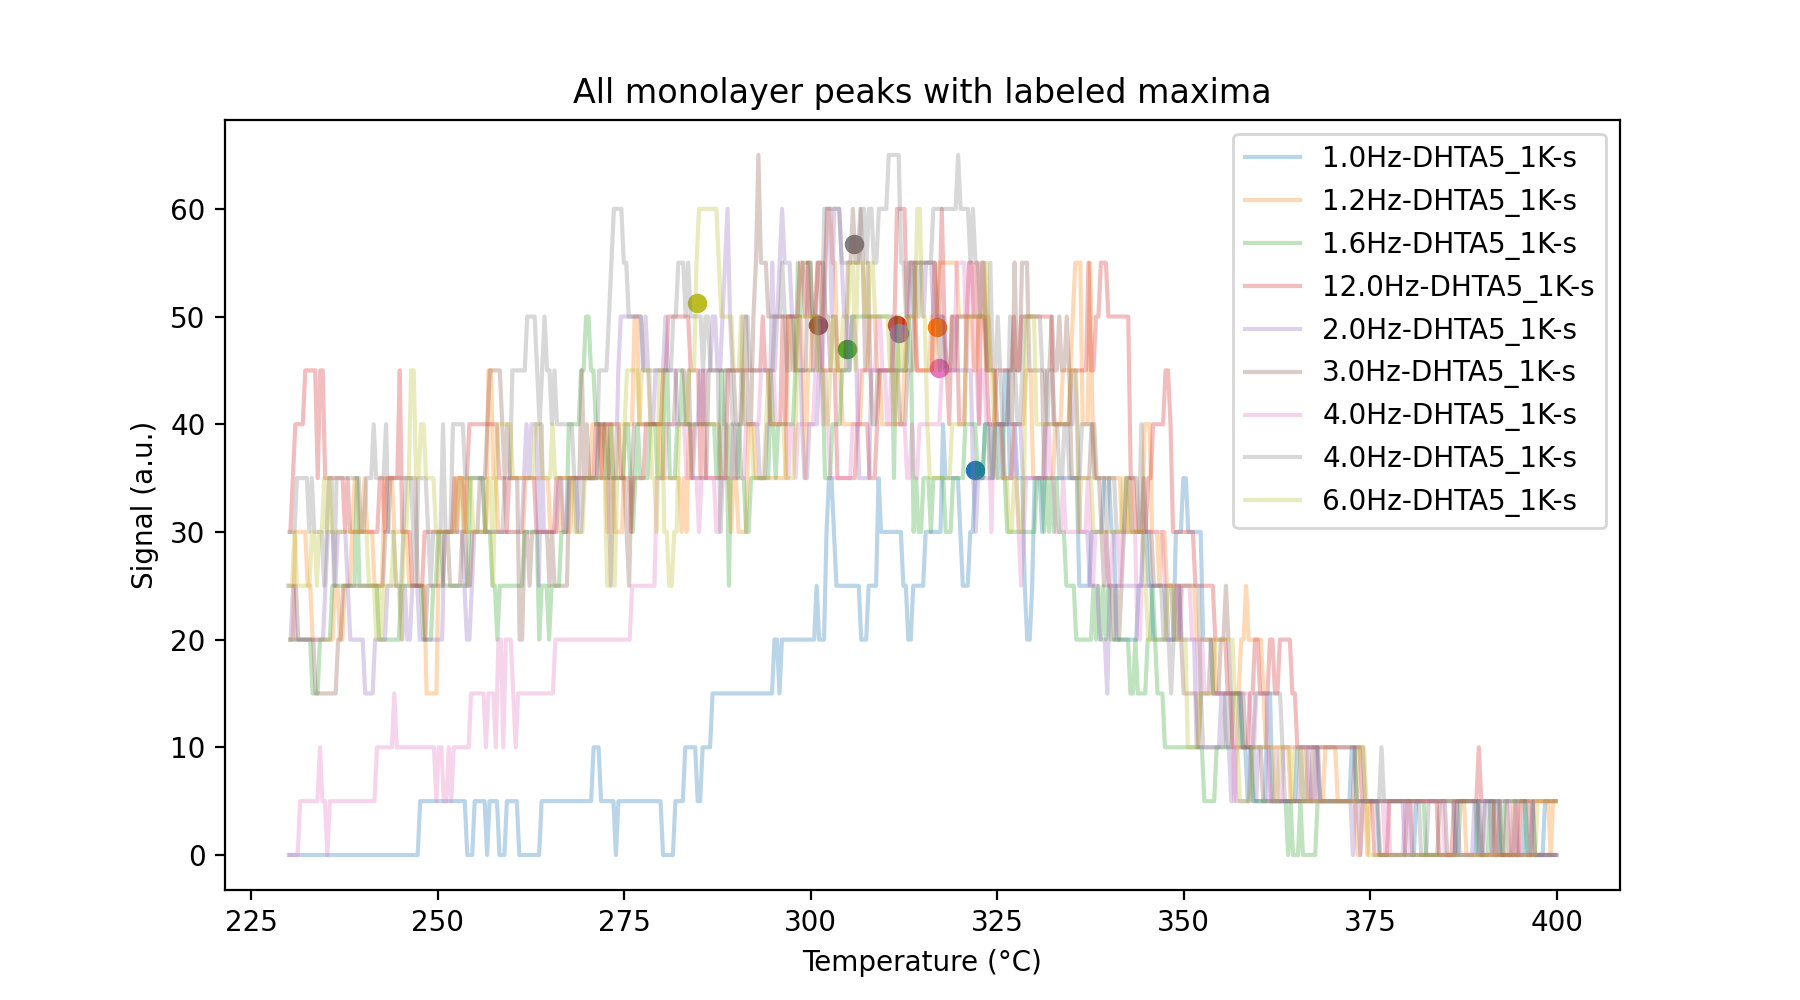

In [37]:
# And now this part of spectra is shown with maxima
fig = plt.figure(figsize=(9, 5), dpi=200, facecolor="white")

for i in range(len(all_data_temp)):
    plt.plot(all_data_temp_reg_bound[i],all_data_median_signal_bound[i],label=legend_for_graph[i], alpha=0.3)
    plt.legend(loc='best')
    
for i in range(len(all_data_temp)):
    plt.scatter(all_maxima[i], all_maxima_y[i])
                 
plt.title('All monolayer peaks with labeled maxima')
plt.xlabel(u'Temperature (\u00B0C)')
plt.ylabel('Signal (a.u.)')
#The file is saved to the output folder
plt.savefig('output/2nd_peak_max_positions.png')
plt.show()

In [38]:
# Now the Redhead energies are calculated and added to a list
all_redhead_energies = []

print('I assume 10^20 for the kinetic coefficient')
kinetic_coeff = 10**20
for maxtemp, rate in zip(all_maxima, all_data_temp_reg_slope):
    energy = redhead(maxtemp,kinetic_coeff,rate)
    all_redhead_energies.append(energy) 

I assume 10^20 for the kinetic coefficient


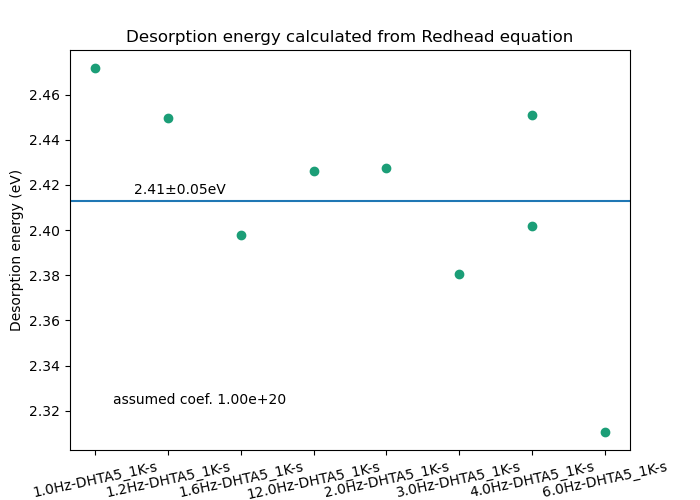

In [39]:
# A horizontal line will be printed showing the mean value 
mean_val = np.mean(all_redhead_energies)
std_val = np.std(all_redhead_energies)

# Here is the graph contating all the Redhead energies
fig = plt.figure(figsize=(7, 5), dpi=100, facecolor="white")
ax = fig.add_axes( [.1, .1, .8, .8] )
#''

# These lines will be printed on the graph
title = 'Desorption energy calculated from Redhead equation' 
text_over_line =  "%.2f" % mean_val, u"\u00B1", "%.2f" % std_val,'eV' 
text_over_line = ''.join(text_over_line)
text_corner = 'assumed coef. ' '{:.2e}'.format(kinetic_coeff)

plt.scatter(short_names, all_redhead_energies,     
    linestyle       = '-',       
    color           ='#1b9e77',
    linewidth       = 1.0, )
plt.title(title)
plt.axhline(y=mean_val)
plt.text( 
    180, 310, text_over_line,
    ha='center', va='center',
    transform=None
)
plt.text(
    200, 100, text_corner,
    ha='center', va='center',
    transform=None
)
plt.xlabel('Source of data')
plt.ylabel('Desorption energy (eV)')
plt.xticks(rotation=12)

#The file is saved to the output folder
plt.savefig('output/redhead.png')

plt.show()

In [40]:
# All the results are zipped and added to a dataframe and are exported    
df = pd.DataFrame(list(zip(all_data_names, short_names,all_0th_energies, all_0th_kintetic, all_maxima, all_redhead_energies )), columns =['File name', 'Short name', 'Des. energy of the 1st peak', 'Kinetic coff. for the 1st peak', 'temp of the 2nd peak (degC)' ,'Redhead energy']) 

df.to_csv(r'output\all_desorption_parameters.csv', index = False, header=True)

df

,File name,Short name,Des. energy of the 1st peak,Kinetic coff. for the 1st peak,temp of the 2nd peak (degC),Redhead energy
0,TDS_TiO2(110)_120121_6CC_1.0Hz-DHTA5_1K-s_2xPI...,1.0Hz-DHTA5_1K-s,0.000000,9.978565e-01,322.062633,2.471739
1,TDS_TiO2(110)_120121_6CC_1.2Hz-DHTA5_1K-s_2xPI...,1.2Hz-DHTA5_1K-s,1.200195,6.770328e+14,316.890318,2.449473
2,TDS_TiO2(110)_120121_6CC_1.6Hz-DHTA5_1K-s_2xPI...,1.6Hz-DHTA5_1K-s,0.000000,9.978565e-01,304.898807,2.398026
3,TDS_TiO2(110)_120121_6CC_12.0Hz-DHTA5_1K-s_2xP...,12.0Hz-DHTA5_1K-s,1.471030,5.607671e+18,311.584140,2.426385
4,TDS_TiO2(110)_120121_6CC_2.0Hz-DHTA5_1K-s_2xPI...,2.0Hz-DHTA5_1K-s,1.149908,6.272865e+14,311.817317,2.427480
5,TDS_TiO2(110)_120121_6CC_3.0Hz-DHTA5_1K-s_2xPI...,3.0Hz-DHTA5_1K-s,0.932098,8.369299e+11,301.002750,2.380759
6,TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPI...,4.0Hz-DHTA5_1K-s,0.109833,2.130460e+01,317.260174,2.451034
7,TDS_TiO2(110)_120121_6CC_4.0Hz-DHTA5_1K-s_2xPI...,4.0Hz-DHTA5_1K-s,1.039563,5.574143e+13,305.829536,2.401778
8,TDS_TiO2(110)_120121_6CC_6.0Hz-DHTA5_1K-s_2xPI...,6.0Hz-DHTA5_1K-s,1.269358,3.303545e+16,284.708271,2.310620


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">The End</p>